<a href="https://colab.research.google.com/github/trevor-webster/2024Fall-MOCS/blob/main/Assignment2CellularAutomata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment #2**
Carina Manitius, Trevor Webster, Derek Devine, Nate Borland

# 1

$$\frac{dN_1}{dt} = \frac{r_1 N_1(K_1 - N_1 - \alpha_{12} N_2)}{K1}$$
$$\frac{dN_2}{dt} = \frac{r_2 N_2(K_2 - N_2 - \alpha_{21} N_1)}{K2}$$



In [ ]:
import numpy as np
import random

# Random walker
def run_random_walker(world, position, history, steps):
    N1 = world.shape[0]
    N2 = world.shape[1]
    (i,j) = position
    for k in range(steps): #for every step
        for i in np.arange(0, N1, 1):
          for j in np.arange(0, N2, 1):
            world[position] = 0.67
            (i,j) = position
            die = random.uniform(0, 1)
            if die<0.5: #bottom step
              world[position] = 1
            history.append(position)

    return (world,position,history)

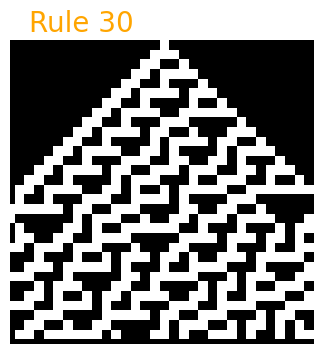

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import random

from IPython import display
from time import sleep

# Parameters
N, S, K, steps = 32, 2, 3, 32 #size, states, neighbors, steps
get_next_state = 30 #rule number
tape = np.zeros(N) #initial conditions of zero
tape[N//2] = 1 #initial conditions
#tape = np.random.randint(2, size=N) #random initial conditions

# Run the CA
#tapes = run_1d_CA(steps,tape)
#tapes = run_rule_30(steps,tape)
tapes = run_cellauto(S, K, decode_rule(get_next_state, S, K), steps, tape) #run model

# Plot everything slowly, one generation at a time
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0,N)
ax.set_ylim(0,steps)
plt.axis('off')
ax.set_aspect('equal')
for i in range(steps):
    temp = np.zeros((steps,N))
    temp[0:i,:] = tapes[0:i,:]
    plt.imshow(np.flipud(temp), cmap=plt.get_cmap(cm.bone))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Add rule label
#ax.text(2, steps+0.5, f'Cellular automaton', color='Orange', fontsize=20)
ax.text(2, steps+0.5, f'Rule {get_next_state}', color='Orange', fontsize=20)
plt.show()

# City Growth

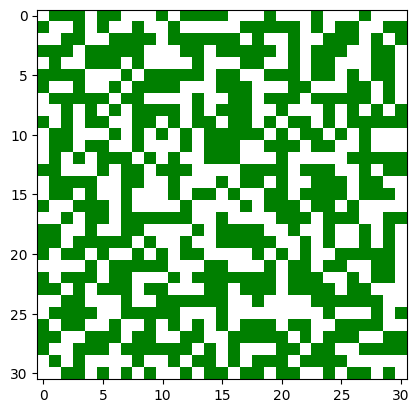

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display

import time

# special rule indexing schema
# number indicates bit offset from the right
# + or - indicates center being 1 or 0, respectively
# [ 0 ][ 1 ][ 2 ]
# [ 3 ][+/-][ 4 ]
# [ 5 ][ 6 ][ 7 ]
# for byte with bit indices 76543210
# bit indices count right to left, which is confusing
# neighbor indices go left to right, top to bottom
#
# for example
# 97 = 01100001
# [ 1 ][ 0 ][ 0 ]
# [ 0 ][ 1 ][ 0 ]
# [ 1 ][ 1 ][ 0 ]
#
# -174 = -10101110
# [ 0 ][ 1 ][ 1 ]
# [ 1 ][ 0 ][ 0 ]
# [ 1 ][ 0 ][ 1 ]

# special rule types & values
two_opposing = 0

# each rule here sets a specific chance for specific orientations (only works on moore neighborhood radius 1)
# a rule number can be calculated by adding up the values in each square below
# indices by decimal value
# [ 1 ][ 2 ][ 4 ]
# [ 8 ][*-1][ 16]
# [ 32][ 64][128]
# ex: a rule for the top right and bottom left being active would be 4 + 32 = 36
# ex: a rule for all 3 bottom cells being active would be 32 + 64 + 128 = 224
# 
# current rule set: each combination of exactly two neighbors that are not adjacent (diagonals not considered adjacent here) uses the two_opposing chance defined above as 0
special_rule_dict = {
# 1 + opposite corner
    5 : two_opposing,
    33 : two_opposing,
    65 : two_opposing,
    129 : two_opposing,
    17 : two_opposing,
# 2 + opposite side
    10 : two_opposing,
    34 : two_opposing,
    66 : two_opposing,
    130 : two_opposing,
    18 : two_opposing,
# 4 + opposite corner
    5 : two_opposing,
    12 : two_opposing,
    36 : two_opposing,
    68 : two_opposing,
    132 : two_opposing,
# 8 + opposite side
    24 : two_opposing,
    136 : two_opposing,
    72 : two_opposing,
# 16 + opposite side
    48 : two_opposing,
    80 : two_opposing,
# 32 + opposite side
    160 : two_opposing,
}

world_size = 31 # @param {type:"slider", min:0, max:111, step:1}

# default chance to turn into a city for each possible number of city neighbors
default_chance_0 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_1 = 0.2 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_2 = 0.4 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_3 = 0.6 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_4 = 0.4 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_5 = 0.2 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_6 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_7 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
default_chance_8 = 0 # @param {type:"slider", min:0, max:1, step:0.01}

# list of default urbanization chances
default_chances = [default_chance_0, default_chance_1, default_chance_2, default_chance_3, default_chance_4, default_chance_5, default_chance_6, default_chance_7, default_chance_8]

# radius of the neighborhood considered for each cell update
# compute used increases drastically as this increases
neighborhood_radius = 2 # param {type:"slider", min:0, max:5, step:1}

# toggles use of the special_rule_dict, disabling will default to basic neighbor count rules
use_special_rules = False # @param {type:"boolean"}

# toggles display of intermediate steps, disabling will skip to the end state and is much faster
animate_growth = True # @param {type:"boolean"}

# forced sleep on every update, for slowing down animations for very fast rule sets
forced_sleep = 0 # param {type:"slider", min:0, max:1, step:0.1}

# r_growth_rate = 1 # @param {type:"slider", min:0, max:1, step:0.01}
# K = 9 - 1

# displays the current state of world cells
def display_world(world):
    plt.imshow(np.flipud(world), cmap=plt.get_cmap(cm.ocean))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# gets the square neighborhood within radius of the cell at i,j in world
# treats cells with i or j less than 0 or greater than world_size - 1 as 0
def get_neighborhood(world, i, j):
    # WIP better rules that treat indices outside the world as 0, not working
    # print(f'{i},{j}: {radius}')
    # neighborhood = np.zeros(((radius*2)+1,(radius*2)+1))
    # for k in range(i-radius, i+radius+1):
    #     for l in range(j-radius, j+radius+1):
    #         if k < 0 or l < 0 or k >= world_size-2 or l >= world_size-1:
    #             neighborhood[i-k-1][j-l-1] = 0
    #         else:
    #             neighborhood[i-k-1][j-l-1] = world[k][l]
    # return neighborhood

    # old neighborhood rules that ignore exterior cells, caused some undefined behavior at world edges
    return world[max(i-neighborhood_radius,0):min(i+neighborhood_radius+1,world_size),
                 max(j-neighborhood_radius,0):min(j+neighborhood_radius+1,world_size)]

# def logistic_rule(neighbor_count):
#     return np.random.rand() < r_growth_rate * (1 - (neighbor_count/K))

# helper function to get a rule number for a given neighborhood
def get_rule_num(neighborhood):
    if len(neighborhood) < neighborhood_radius*2+1 or len(neighborhood[0]) < neighborhood_radius*2+1:
        return 0
    rule_num = 0
    if neighborhood[0,0] == 1:
        rule_num = rule_num | 1 << 0
    if neighborhood[0,1] == 1:
        rule_num = rule_num | 1 << 1
    if neighborhood[0,2] == 1:
        rule_num = rule_num | 1 << 2
    if neighborhood[1,0] == 1:
        rule_num = rule_num | 1 << 3
    if neighborhood[1,2] == 1:
        rule_num = rule_num | 1 << 4
    if neighborhood[2,0] == 1:
        rule_num = rule_num | 1 << 5
    if neighborhood[2,1] == 1:
        rule_num = rule_num | 1 << 6
    if neighborhood[2,2] == 1:
        rule_num = rule_num | 1 << 7
    if neighborhood[1,1] == 0:
        rule_num *= -1
    return rule_num

## Explicit zoning rules for each neighbor count
def get_next_state(neighborhood):
    rule_num = get_rule_num(neighborhood)
    default_chance = default_chances[min(len(default_chances)-1, np.count_nonzero(neighborhood))]
    
    # tweak as needed to modify how priority works between default and special rules
    # this should only be relevant for neighborhoods with radius > 1
    if use_special_rules and rule_num in special_rule_dict:
        chance = special_rule_dict[rule_num]
    else:
        chance = default_chance
    
    if chance > 0 and np.random.rand() < chance:
        return 1
    else:
        return 0

# checks each cell in world and applies the results of get_next_state
def update_world(world):
    next_world = world.copy()
    reached_edge = False
    for i in range(world_size):
        for j in range(world_size):
            # this saves compute but must be removed if we want city to be able to turn to forest
            if world[i][j] == 1:
                continue
            next_state = get_next_state(get_neighborhood(world, i, j))
            next_world[i][j] = next_state
            if next_state == 1 and (i == 0 or j == 0 or i == world_size-1 or j == world_size-1):
                reached_edge = True
    
    return (next_world, reached_edge)

# set up 'world', a (size x size) 2D array of all zeros (greenspace) with a 1 (concrete) in the center
world = np.zeros((world_size,world_size))
world[world_size//2,world_size//2] = 1

# debugging stuff for WIP get_neighborhood
# world = [[0,1,2,3,4],[5,6,7,8,9],[10,11,12,13,14],[15,16,17,18,19],[20,21,22,23,24]]
# print(world)
# hood = get_neighborhood(world,0,0,1)
# print(hood)
# hood = get_neighborhood(world,2,3,2)
# print(hood)

# set up completion conditions
finished = False
reached_edge = False

# main update loop
while not finished:
    if animate_growth:
        display_world(world)
        # uncomment to slow down very fast rulesets
        # time.sleep(0.1)

    (next_world, touched_edge) = update_world(world)

    # tweaks to completion conditions go here
    if touched_edge:
        reached_edge = True
    if reached_edge and np.array_equal(world, next_world):
        finished = True
    world = next_world

# display final state of the world
display_world(world)

# Greenspace metrics

In [2]:
from scipy.ndimage import label

# 1. Metric: share_greenspace (% of greenspace cells)
def share_greenspace(world):
    total_cells = world_size * world_size
    greenspace_cells = np.sum(world == 0)
    return greenspace_cells / total_cells

# 2. Metric: biggest_greenspace (largest cluster of contiguous greenspace cells)
def biggest_greenspace(world):
    # Using scipy's label function to identify contiguous clusters of 0's (greenspace)
    labeled_world, num_features = label(world == 0)
    if num_features == 0:
        return 0
    # Find the size of each cluster and return the largest
    sizes = np.bincount(labeled_world.ravel())
    return sizes[1:].max()  # exclude the background (index 0)

# 3. Metric: access_greenspace (urban cells bordering greenspace)
def access_greenspace(world):
    access_count = 0
    total_urban_cells = np.sum(world == 1)  # count the number of urban cells
    for i in range(world_size):
        for j in range(world_size):
            if world[i][j] == 1:  # only look at urban cells
                # Get von Neumann neighborhood (up, down, left, right)
                neighbors = [
                    (i-1, j),  # up
                    (i+1, j),  # down
                    (i, j-1),  # left
                    (i, j+1)   # right
                ]
                for ni, nj in neighbors:
                    if 0 <= ni < world_size and 0 <= nj < world_size and world[ni][nj] == 0:
                        access_count += 1
                        break  # no need to check further if greenspace is found

    if total_urban_cells == 0:
        return 0  # avoid division by zero if there are no urban cells

    return access_count / total_urban_cells  # return percentage

# 4. Metric: average_greenspace (average size of greenspace clusters)
def average_greenspace(world):
    labeled_world, num_features = label(world == 0)
    if num_features == 0:
        return 0
    # Find the size of each cluster
    sizes = np.bincount(labeled_world.ravel())
    return sizes[1:].mean()  # exclude the background (index 0)

# Compute and display the metrics
final_share_greenspace = share_greenspace(world)
final_biggest_greenspace = biggest_greenspace(world)
final_access_greenspace = access_greenspace(world)
final_average_greenspace = average_greenspace(world)

print(f"Share of Greenspace: {final_share_greenspace:.2%}")
print(f"Largest Greenspace Cluster: {final_biggest_greenspace} cells")
print(f"Percentage of Urban Cells with Greenspace Access: {final_access_greenspace:.2%}")
print(f"Average Greenspace Cluster Size: {final_average_greenspace:.2f} cells")

Share of Greenspace: 55.57%
Largest Greenspace Cluster: 244 cells
Percentage of Urban Cells with Greenspace Access: 96.96%
Average Greenspace Cluster Size: 15.71 cells


# Loop
Loops the simulation to run for a bunch of times and gets the average of the 4 metrics across all of the runs

In [3]:
# Number of simulation runs
num_runs = 100  # Change this to the desired number of runs

# Initialize lists to store metrics for each run
share_greenspace_list = []
biggest_greenspace_list = []
access_greenspace_list = []
average_greenspace_list = []

# Run the simulation multiple times
for run in range(num_runs):
    # Reset world for each run
    world = np.zeros((world_size, world_size))
    world[world_size // 2, world_size // 2] = 1  # starting condition with one urban cell in the center

    finished = False
    reached_edge = False

    # Main update loop for the simulation
    while not finished:
        (next_world, touched_edge) = update_world(world)

        if touched_edge:
            reached_edge = True
        if reached_edge and np.array_equal(world, next_world):
            finished = True
        world = next_world

    # Compute metrics for the final state of the world
    final_share_greenspace = share_greenspace(world)
    final_biggest_greenspace = biggest_greenspace(world)
    final_access_greenspace = access_greenspace(world)  
    final_average_greenspace = average_greenspace(world)

    # Append metrics to their respective lists
    share_greenspace_list.append(final_share_greenspace)
    biggest_greenspace_list.append(final_biggest_greenspace)
    access_greenspace_list.append(final_access_greenspace)
    average_greenspace_list.append(final_average_greenspace)

# Calculate averages of the metrics
average_share_greenspace = np.mean(share_greenspace_list)
average_biggest_greenspace = np.mean(biggest_greenspace_list)
average_access_greenspace = np.mean(access_greenspace_list)
average_average_greenspace = np.mean(average_greenspace_list)

# Print the average metrics across all runs
print(f"Average Share of Greenspace: {average_share_greenspace:.2%}")
print(f"Average Largest Greenspace Cluster: {average_biggest_greenspace:.2f} cells")
print(f"Average Percentage of Urban Cells with Greenspace Access: {average_access_greenspace:.2%}")
print(f"Average Greenspace Cluster Size: {average_average_greenspace:.2f} cells")

Average Share of Greenspace: 54.16%
Average Largest Greenspace Cluster: 136.78 cells
Average Percentage of Urban Cells with Greenspace Access: 96.69%
Average Greenspace Cluster Size: 10.85 cells


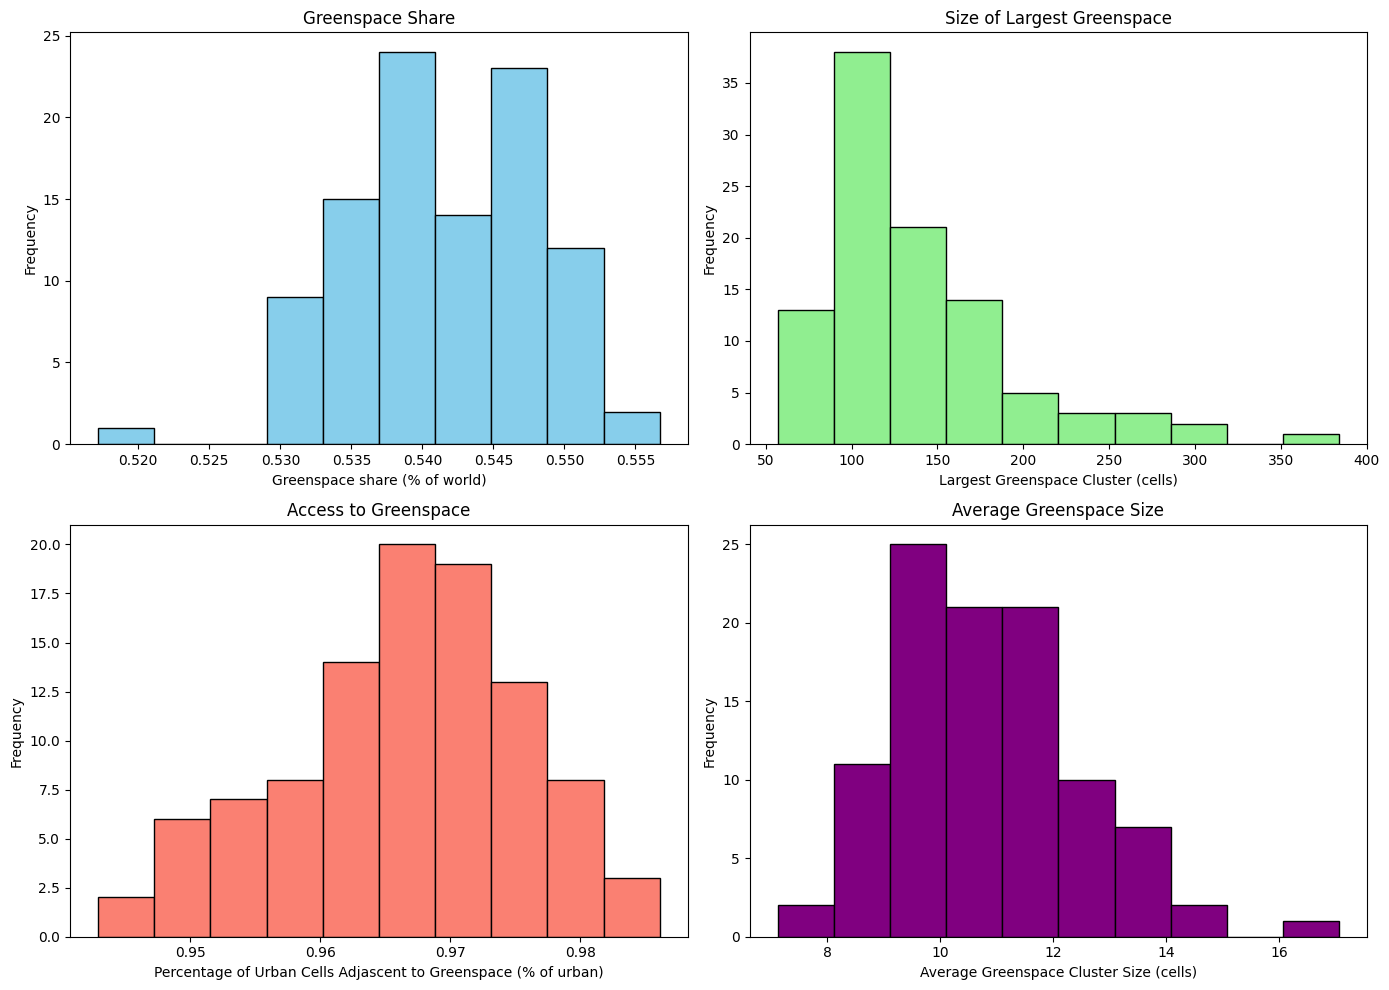

In [4]:
# Plotting histograms for each metric
plt.figure(figsize=(14, 10))

# Share of Greenspace
plt.subplot(2, 2, 1)
plt.hist(share_greenspace_list, bins=10, color='skyblue', edgecolor='black')
plt.title('Greenspace Share')
plt.xlabel('Greenspace share (% of world)')
plt.ylabel('Frequency')

# Largest Greenspace Cluster
plt.subplot(2, 2, 2)
plt.hist(biggest_greenspace_list, bins=10, color='lightgreen', edgecolor='black')
plt.title('Size of Largest Greenspace')
plt.xlabel('Largest Greenspace Cluster (cells)')
plt.ylabel('Frequency')

# Access to Greenspace
plt.subplot(2, 2, 3)
plt.hist(access_greenspace_list, bins=10, color='salmon', edgecolor='black')
plt.title('Access to Greenspace')
plt.xlabel('Percentage of Urban Cells Adjascent to Greenspace (% of urban)')
plt.ylabel('Frequency')

# Average Greenspace Cluster Size
plt.subplot(2, 2, 4)
plt.hist(average_greenspace_list, bins=10, color='purple', edgecolor='black')
plt.title('Average Greenspace Size')
plt.xlabel('Average Greenspace Cluster Size (cells)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
#plt.savefig('/Users/carinamanitius/Desktop/' + 'share_greenspace_distribution.jpg', format='jpg', dpi=300)
plt.show()